# **Phase 2 Project Notebook - King County House Sales Dataset**

### Authors: Samantha, Ian, Sanjit

# Table of Contents

# Business Understanding

# Data Understanding and Preparation

First we shall install the necessary packages that we will need going forward with our exploration.

In [1]:
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
%matplotlib inline

# Statistical Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as stats

# Predictive Modeling
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures

from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error 

# Custom-made tools
import tools.helpers as th
import tools.data_preparation as dp
import tools.data_visualization as dv

### Importing the dataset and cleaning it

We import the csv file and run it through our first step of the cleaning process. <code>dp.initial_clean()</code> is a helper function can be found in the <code>"data_preparation.py"</code> file within the <code>"tools"</code> folder of this repository. 


What <code>dp.initial_clean()</code> does is: 

- Drop the <code>id</code> column. 
- Convert the <code>date</code> column values to DateTime format using <code>pd.to_datetime</code>.
- Convert the <code>'sqft_basement'</code> column values to float, coerce the '?' to NaN values.
- Mode fill <code>NaN</code> values in the columns: <code>waterfront</code>, <code>yr_renovated</code>, and <code>view</code>.
- Removes outliers using the `remove_outliers` function, dropping values that have a z-score higher than 3
- Adds a feature calculating each house's distance from the center of the zipcode with the highest average price

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
final_df = dp.initial_clean(df)

Using <code>.info()</code> we take a look at what our dataset looks like after our initial clean. It can be seen here that there are no <code>null</code> values and the values in all columns except <code>date</code> are either stored in <code>float64</code> or <code>int64</code> format.

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20552 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              20552 non-null  datetime64[ns]
 1   price             20552 non-null  float64       
 2   bedrooms          20552 non-null  int64         
 3   bathrooms         20552 non-null  float64       
 4   sqft_living       20552 non-null  int64         
 5   sqft_lot          20552 non-null  int64         
 6   floors            20552 non-null  float64       
 7   waterfront        20552 non-null  float64       
 8   view              20552 non-null  float64       
 9   condition         20552 non-null  int64         
 10  grade             20552 non-null  int64         
 11  sqft_above        20552 non-null  int64         
 12  sqft_basement     20552 non-null  float64       
 13  yr_built          20552 non-null  int64         
 14  yr_renovated      2055

#### Plotting Histograms.

Let us now see if we can find anything interesting in the distributions of the columns in our dataset.

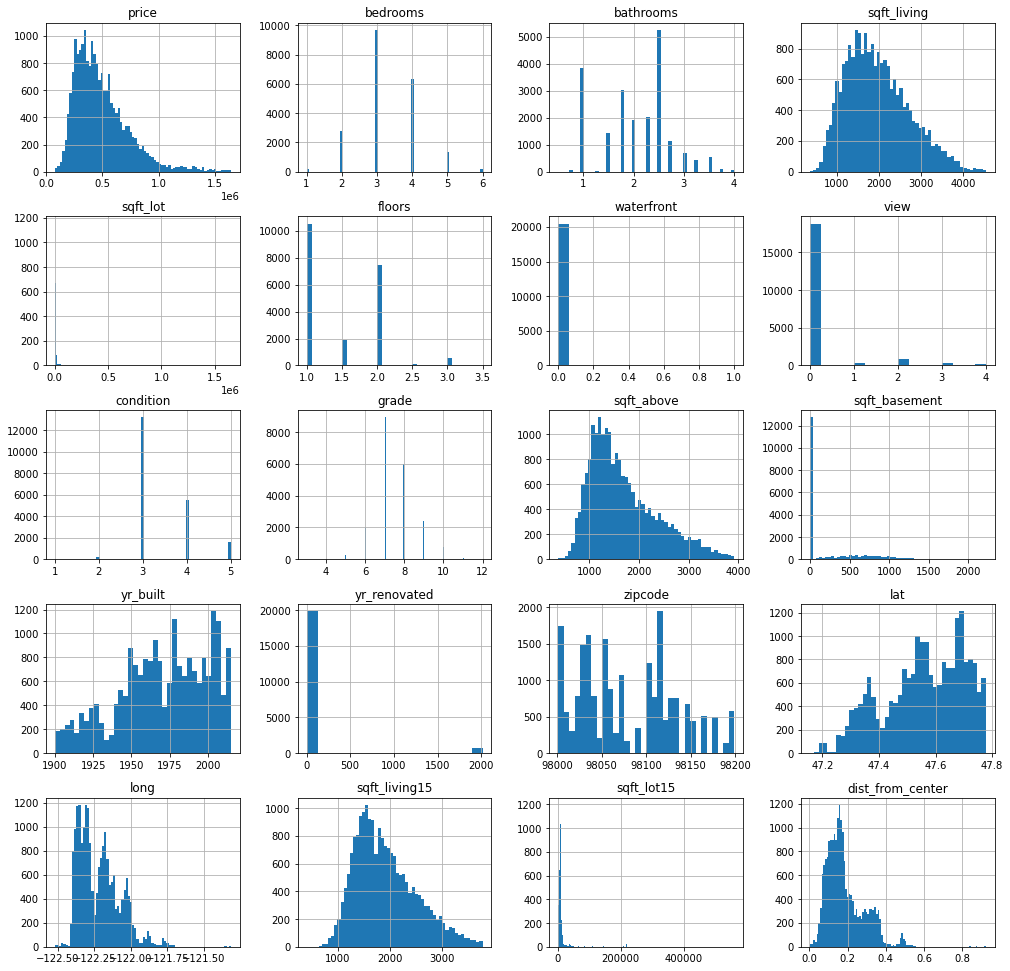

In [4]:
final_df.hist(figsize=(17, 17), bins='auto');

We can see from the above visualizations that our target column <code>price</code> is heavily skewed to the right. The same can be said about the columns <code>sqft_living</code> and <code>sqft_above</code> as well. The columns <code>long</code> and <code>sqft_living15</code> are right-skewed as well but seemingly not as much as the previously mentioned two columns. 

#### add more here ^^^^

#### Finding correlations with  <code>price</code>.

Now we shall focus on our target <code>price</code> column and examine its relation with other columns in order to identify potential predictors for our first model.

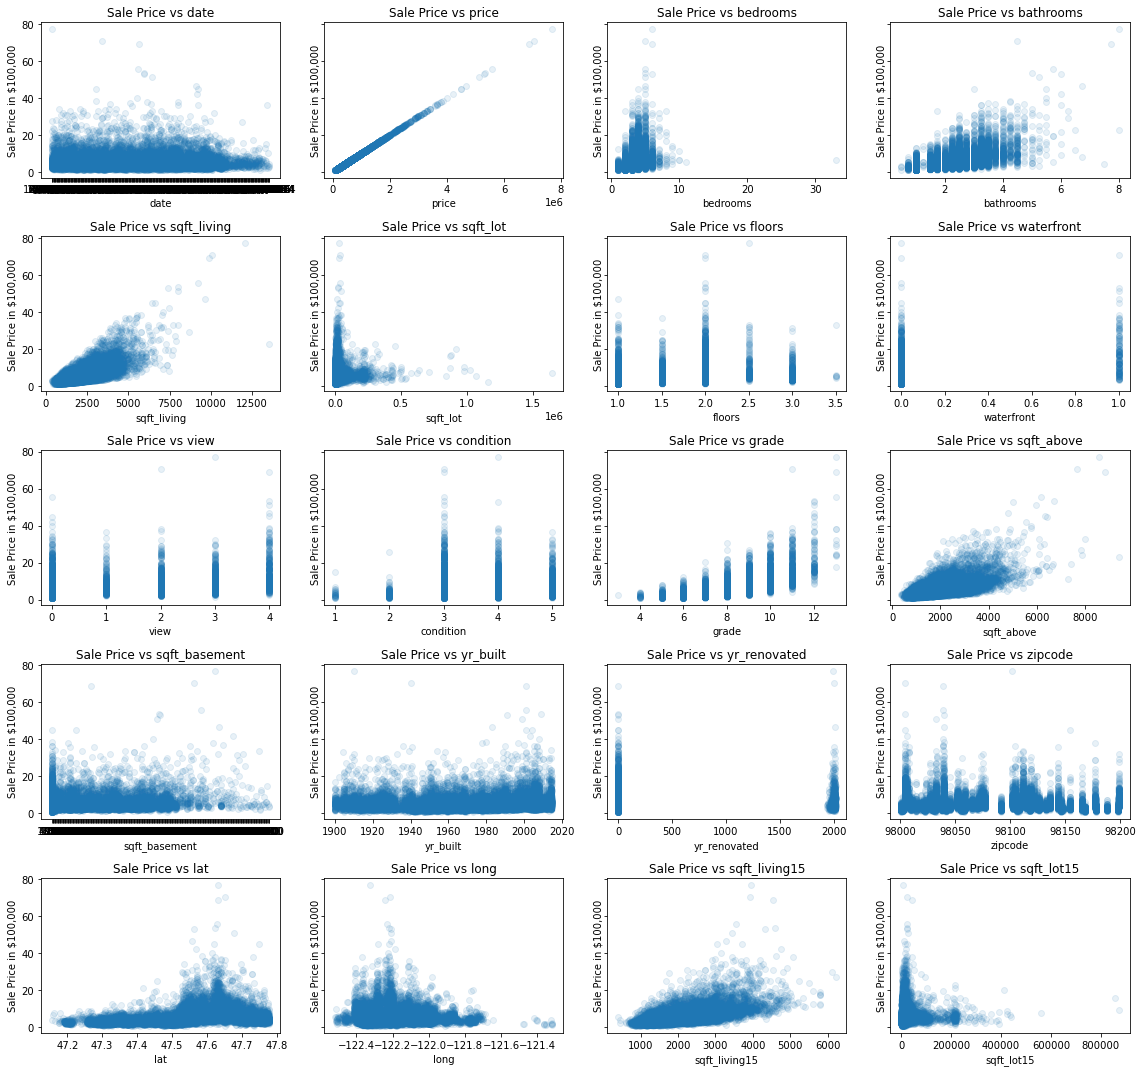

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), final_df.columns):
    ax.scatter(df[column], df['price'] / 100_000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

At first glance, we can infer that our <code>price</code> data may have a positive correlation with the following columns:

- <code>sqft_living</code>
- <code>sqft_above</code>
- <code>sqft_living15</code>

The columns <code>floors</code>, <code>waterfront</code>, <code>view</code>, <code>condition</code>, <code>grade</code> and <code>yr_renovated</code> can be treated as categorical variables.


#### add more here ^^^^

#### Comparing Feature Multicollinearity

We use a custom function from the <code>data_visualization.py</code> file that takes a dataframe as an argument and returns a Seaborn visual of our features' multicollinearity. Every column from our dataset is compared against one another to identify how strong the correlation is between them. This can be helpful when selecting features that don't have strong multicollinearity, given how important this is for our predictive model to perform well.

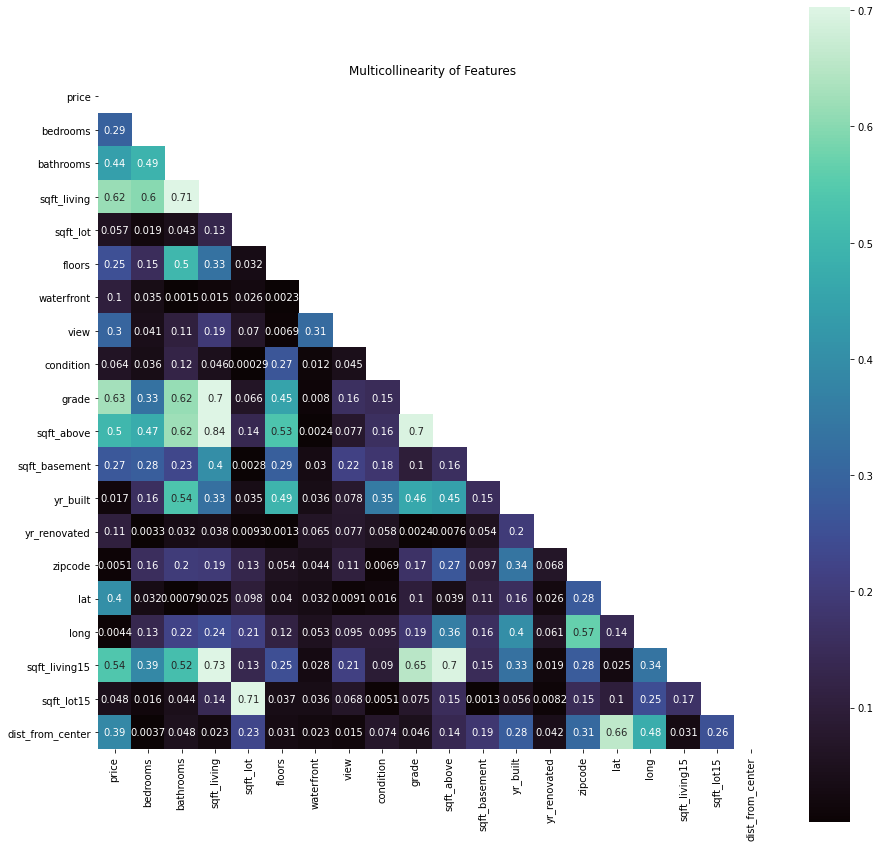

In [6]:
dv.corr_heatmap(final_df)

## Visualizing King County and identifying the most expensive Zip Codes

To create a high-quality visual for our analysis, we downloaded the <code>king_county_zipcodes.geojson</code> from <a href="https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/about">here</a>.

In [7]:
with open('data/king_county_zipcodes.geojson') as f:
    zipcode_geojson = json.load(f)

In [8]:
kc_zipcodes = final_df['zipcode'].unique()
zipcode_geojson['features'] = [feature for feature in zipcode_geojson['features'] if feature['properties']['ZIP'] in kc_zipcodes]

In [9]:
average_lat, average_long = final_df[['lat', 'long']].mean()
average_lat, average_long

(47.55811774523159, -122.21667594394663)

In [10]:
zipcode_avg_price = final_df.groupby('zipcode')[['price', 'lat', 'long']].mean().reset_index().sort_values('price', ascending=False)

zipcode_avg_price

zipcode         price        lat        long
24    98039  1.220882e+06  47.627306 -122.233412
3     98004  9.987986e+05  47.613671 -122.203206
25    98040  9.795895e+05  47.560094 -122.225426
48    98112  8.746252e+05  47.629481 -122.299000
47    98109  7.976321e+05  47.635806 -122.349833
..      ...           ...        ...         ...
61    98148  2.798186e+05  47.437482 -122.329339
0     98001  2.779730e+05  47.309013 -122.270668
20    98032  2.489277e+05  47.373700 -122.278758
64    98168  2.389863e+05  47.489773 -122.308000
1     98002  2.326047e+05  47.308752 -122.213311

[70 rows x 4 columns]

In [11]:
m = folium.Map(
    location=[average_lat, average_long],
    width='75%',
    length='75%',
    zoom_start=10
)

In [12]:
tooltips = folium.features.GeoJsonTooltip(
    fields=['ZIP']
)

In [13]:
highest_price, lat, long = zipcode_avg_price.iloc[0, 1:]

folium.Marker(
    location=[lat, long],
    tooltip=f"Average Price: ${highest_price:,.0f}"
).add_to(m);

In [14]:
choropleth = folium.Choropleth(
    geo_data=zipcode_geojson,
    data=zipcode_avg_price,
    columns=['zipcode', 'price'],
    key_on="feature.properties.ZIP",
    nan_fill_color=None,
    fill_color="YlOrRd",
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Sale Price ($)' 
)

choropleth.geojson.add_child(tooltips)
choropleth.add_to(m);

In [15]:
m

In [16]:
m.save('images/price_choropleth.png')

In [17]:
model = smf.ols('price~sqft_living', final_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.258e+04
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:01:14   Log-Likelihood:            -2.7897e+05
No. Observations:               20552   AIC:                         5.579e+05
Df Residuals:                   20550   BIC:                         5.580e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.588e+04   3765.190     25.464      0.000    8.85e+04    1.03e+05
sqft_living   201.1993      1.794    112.163      0.000     197.683     204.715
==============================================================================
Omnibus:                     3837.802   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8794.646
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                       5.389   Cond. No.                     5.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Modeling

In [18]:
X = final_df.drop('price', axis=1)
y = final_df['price']

## Baseline

In [19]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X, y)

DummyRegressor()

In [46]:
dummy_regr.score(X, y)

0.0

In [20]:
y_hat_dummy = dummy_regr.predict(X)
residuals_dummy = y_hat_dummy - y

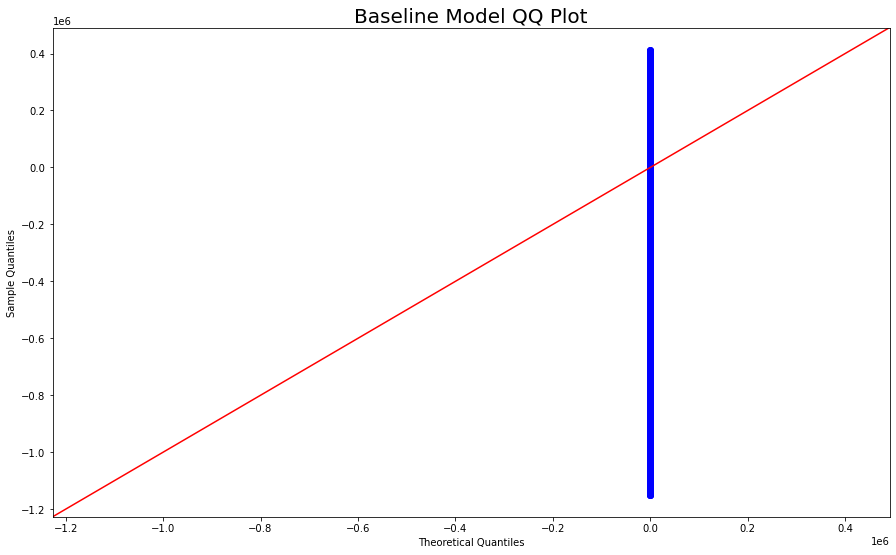

In [21]:
fig, ax = plt.subplots(figsize=(15, 9))

ax.set_title('Baseline Model QQ Plot', size=20)
fig = sm.graphics.qqplot(residuals_dummy, dist=stats.norm, line='45', ax=ax)

## Simple Linear Regression

In [24]:
#simple model comparing sqft_living with price
X_int = sm.add_constant(X['sqft_living'])
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.258e+04
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:16:20   Log-Likelihood:            -2.7897e+05
No. Observations:               20552   AIC:                         5.579e+05
Df Residuals:                   20550   BIC:                         5.580e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.588e+04   3765.190     25.464      0.000    8.85e+04    1.03e+05
sqft_living   201.1993      1.794    112.163      0.000     197.683     204.715
==============================================================================
Omnibus:                     3837.802   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8794.646
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                       5.389   Cond. No.                     5.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

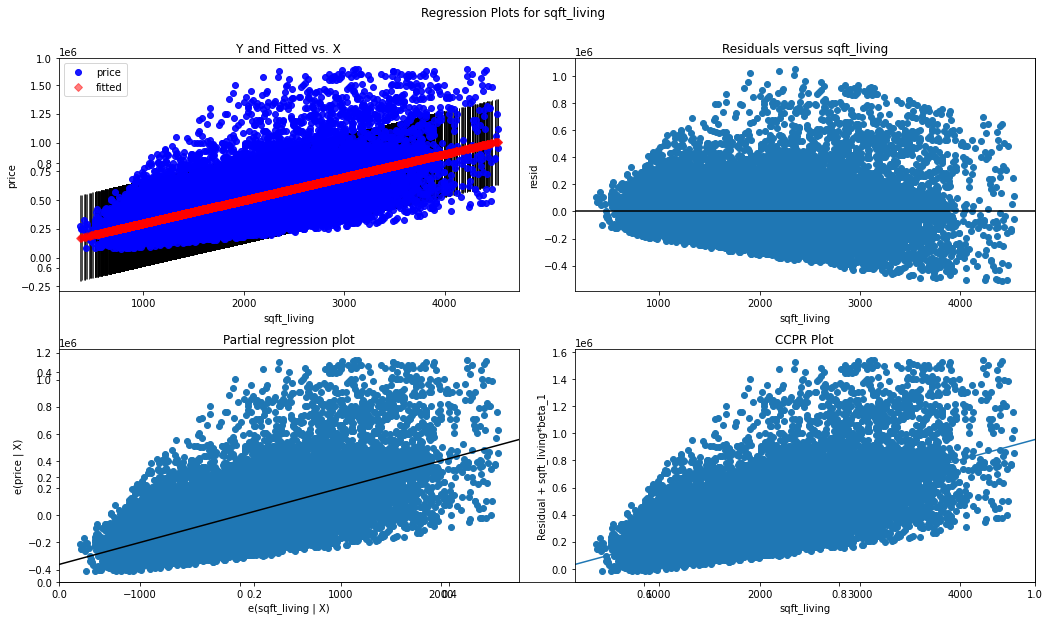

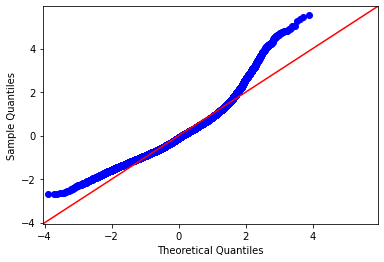

In [25]:
fig, ax = plt.subplots(figsize=(15, 9))

fig = sm.graphics.plot_regress_exog(model, 'sqft_living', fig=fig)
fig = sm.qqplot(model.resid, dist=stats.norm, line='45', fit=True)


## Multiple Linear Regression

This function calculates pairwise correlations between each of the features in the dataset in order to determine which features to drop to decrease the conditional number of our multiple linear regression model. We decided on a cutoff of 0.70 for the correlation coefficient.

In [43]:
th.predictor_corrs(final_df, 0.70)

r
pairs                                 
(sqft_living, sqft_above)     0.835899
(sqft_living15, sqft_living)  0.727438
(sqft_lot, sqft_lot15)        0.708127
(sqft_living, bathrooms)      0.707537
(sqft_living, grade)          0.701825

We decided to drop the following columns because 

In [40]:
# creating a new dataframe that removes collinear columns
df_test = final_df.drop(columns=[
    'date',
    'sqft_above',
    'grade',
    'sqft_living15', 
    'sqft_lot15', 
    'sqft_lot', 
    'bathrooms',
    'sqft_basement',
    'zipcode'
])
df_test.head()

price  bedrooms  sqft_living  floors  waterfront  view  condition  \
0  221900.0         3         1180     1.0         0.0   0.0          3   
1  538000.0         3         2570     2.0         0.0   0.0          3   
2  180000.0         2          770     1.0         0.0   0.0          3   
3  604000.0         4         1960     1.0         0.0   0.0          5   
4  510000.0         3         1680     1.0         0.0   0.0          3   

   grade  yr_built  yr_renovated      lat     long  dist_from_center  
0      7      1955           0.0  47.5112 -122.257          0.118478  
1      7      1951        1991.0  47.7210 -122.319          0.126901  
2      6      1933           0.0  47.7379 -122.233          0.110595  
3      7      1965           0.0  47.5208 -122.393          0.191864  
4      8      1987           0.0  47.6168 -122.045          0.188704

In [41]:
# set X and y variables 
X = pd.DataFrame(df_test.drop('price', axis=1))
y = df_test.price

# pass variables into train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train Score:', lr.score(X_train, y_train))
print('Validation Score:', lr.score(X_test, y_test))

Train Score: 0.6947221366695825
Validation Score: 0.6883104991196916


**Find RMSE**

In [47]:
predictions = lr.predict(X_test)

RMSE = mean_squared_error(y_test, predictions, squared=False)
print('Second RMSE: $', round(RMSE, 2))

Second RMSE: $ 136006.95


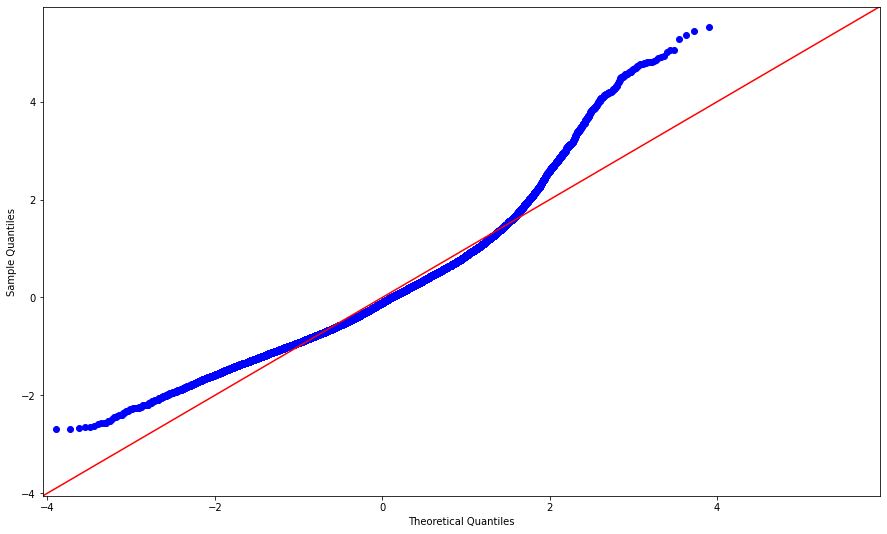

In [58]:
fig, ax = plt.subplots(figsize=(15, 9))
fig = sm.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)

## MLR with Polynomial Features

In [48]:
# log transform continuous variables
to_log = ['price', 'sqft_living', 'dist_from_center', 'lat']
th.log_transform(df_test, to_log)

In [49]:
# fit 2 into polynomial features
poly_2 = PolynomialFeatures(2)

# set X and y variables 
X = pd.DataFrame(
            poly_2.fit_transform(df_test.drop('price', axis=1))
                      )
y = df_test.price

# pass variables into train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

In [50]:
display(X_train.head(2))
display(X_test.head(2))

0    1         2    3    4    5    6    7       8    9   ...   81  \
3298   1.0  3.0  7.501082  1.0  0.0  0.0  4.0  7.0  1941.0  0.0  ...  0.0   
18149  1.0  2.0  7.313220  1.0  0.0  0.0  3.0  8.0  1933.0  0.0  ...  0.0   

        82   83   84         85          86        87            88  \
3298   0.0 -0.0 -0.0  14.896810 -472.659061 -4.772443  14996.941444   
18149  0.0 -0.0 -0.0  14.928113 -472.734263 -8.180522  14970.256609   

               89        90  
3298   151.424253  1.528932  
18149  259.055715  4.482880  

[2 rows x 91 columns]

0    1         2    3    4    5    6    7       8    9   ...   81  \
7256   1.0  4.0  7.365180  1.0  0.0  0.0  3.0  7.0  1953.0  0.0  ...  0.0   
11443  1.0  3.0  6.937314  1.0  0.0  0.0  4.0  7.0  1968.0  0.0  ...  0.0   

        82   83   84         85          86        87            88  \
7256   0.0 -0.0 -0.0  14.936398 -472.138854 -9.131641  14924.287225   
11443  0.0 -0.0 -0.0  14.906355 -471.756451 -7.926793  14930.151721   

               89        90  
7256   288.650736  5.582796  
11443  250.867205  4.215252  

[2 rows x 91 columns]

In [51]:
lr.fit(X_train, y_train)
print('Train Score:', lr.score(X_train, y_train))
print('Validation Score:', lr.score(X_test, y_test))

Train Score: 0.8055134834603777
Validation Score: 0.8071982011958461


**Find the RMSE**

In [52]:
predictions = lr.predict(X_test)

In [53]:
# we need to undue the log transform we performed on price to better interpret RMSE
y_test2 = np.exp(y_test)

# remove log transform off predictions to better interpret RMSE
predictions2 = np.exp(predictions)

In [54]:
RMSE = mean_squared_error(y_test2, predictions2, squared=False)
print('Final RMSE: $', round(RMSE, 2))

Final RMSE: $ 117311.37


Text(0, 0.5, 'Predictions')

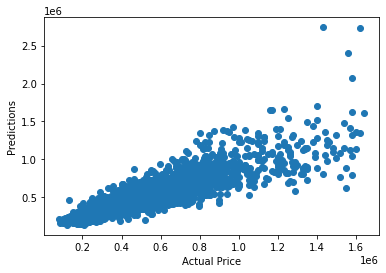

In [55]:
# plotting the actual home prices against the models predictions
ax = plt.subplots()
fig = plt.scatter(y_test2, predictions2)
plt.xlabel('Actual Price')
plt.ylabel('Predictions')

In [56]:
lr_mape = th.MAPE(y_test2, predictions2)
print("MAPE: ", round(lr_mape, 0), '%')

MAPE:  16.0 %


### Gradient Boost Regression ###

Gradient Boost Regression instead of Linear Regression using the same x and y variables from the previous model

In [ ]:
# gradient boost regressor using the df_test
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(loss = 'ls', learning_rate = 0.05, 
                                         n_estimators = 400, max_depth = 5, min_samples_split = 2,)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print('Train Score:', clf.score(X_train, y_train))
print('Validation Score', clf.score(X_test, y_test))

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
# we need to undue the log transform we performed on price to better interpret RMSE
y_test2 = np.expm1(y_test)

# remove log transform off predictions to better interpret RMSE
predictions2 = np.expm1(predictions)

In [ ]:
RMSE = mean_squared_error(y_test2, predictions2, squared=False)
print('Gradient Boost RMSE: $', round(RMSE, 2))

In [ ]:
# plotting the actual home prices against the models predictions
plt.scatter(y_test2, predictions2)
plt.xlabel('Actual Price')
plt.ylabel('Predictions')

## Conclusions